In [1]:
from datetime import datetime

# Writing the Helper Function

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')


def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, f"C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/model.pth")


def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/accuracy.png")

    # Loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/loss.png")


# Preparing the Medical MNIST Dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Required constants.
TRAIN_DIR = 'C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/input/medical_mnist_processed/train'
VALID_DIR = 'C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/input/medical_mnist_processed/valid'
IMAGE_SIZE = 224  # Image size of resize when applying transforms.
BATCH_SIZE = 64
NUM_WORKERS = 4  # Number of parallel processes for data preparation.


# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])
    return train_transform


# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])
    return valid_transform

# Functions to Prepare the Datasets and Data Loaders

def get_datasets():
    """
    Function to prepare the Datasets.

    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR,
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR,
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes


def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.

    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.

    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader


# The PyTorch Neural Network Classifier for Medical MNIST Classification

In [4]:
import torch.nn.functional as F
import torch.nn as nn


class MedicalMNISTCNN(nn.Module):
    def __init__(self, num_classes=None):
        super(MedicalMNISTCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #, padding = 1)
        )

        self.classifier = nn.Sequential(
            
#             nn.Flatten(),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout2d(p=0.4),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.classifier(x)
        return x


## The Training Script

In [5]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

# from model import MedicalMNISTCNN
# from datasets import get_datasets, get_data_loaders
# from utils import save_model, save_plots


# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


# Validation function.
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


## The Main Code 

[INFO]: Number of training images: 41267
[INFO]: Number of validation images: 11790
[INFO]: Class names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

Computation device: cpu
Learning rate: 0.001
Epochs to train for: 20

422,086 total parameters.
422,086 training parameters.
[INFO]: Epoch 1 of 20
Training



Validation



Training loss: 0.209, training acc: 92.900
Validation loss: 0.052, validation acc: 98.550
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training



Validation



Training loss: 0.049, training acc: 98.561
Validation loss: 0.022, validation acc: 98.813
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training



Validation



Training loss: 0.024, training acc: 99.295
Validation loss: 0.010, validation acc: 99.729
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training



Validation



Training loss: 0.019, training acc: 99.409
Validation loss: 0.043, validation acc: 99.084
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training



Validation



Training loss: 0.009, training acc: 99.736
Validation loss: 0.005, validation acc: 99.856
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training



Validation



Training loss: 0.046, training acc: 98.914
Validation loss: 0.023, validation acc: 99.304
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training



Validation



Training loss: 0.008, training acc: 99.748
Validation loss: 0.006, validation acc: 99.881
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training



Validation



Training loss: 0.010, training acc: 99.709
Validation loss: 0.009, validation acc: 99.788
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training



Validation



Training loss: 0.026, training acc: 99.401
Validation loss: 0.008, validation acc: 99.746
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training



Validation



Training loss: 0.007, training acc: 99.777
Validation loss: 0.003, validation acc: 99.907
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training



Validation



Training loss: 0.007, training acc: 99.801
Validation loss: 0.003, validation acc: 99.915
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training



Validation



Training loss: 0.003, training acc: 99.927
Validation loss: 0.003, validation acc: 99.898
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training



Validation



Training loss: 0.008, training acc: 99.789
Validation loss: 0.007, validation acc: 99.746
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training



Validation



Training loss: 0.004, training acc: 99.872
Validation loss: 0.004, validation acc: 99.907
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training



Validation



Training loss: 0.013, training acc: 99.649
Validation loss: 0.002, validation acc: 99.949
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training



Validation



Training loss: 0.005, training acc: 99.852
Validation loss: 0.038, validation acc: 98.974
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training



Validation



Training loss: 0.005, training acc: 99.855
Validation loss: 0.001, validation acc: 99.941
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training



Validation



Training loss: 0.003, training acc: 99.918
Validation loss: 0.002, validation acc: 99.932
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training



Validation



Training loss: 0.007, training acc: 99.826
Validation loss: 0.002, validation acc: 99.932
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training



Validation



Training loss: 0.004, training acc: 99.869
Validation loss: 0.003, validation acc: 99.890
--------------------------------------------------
Duration: 17:27:24.993663
TRAINING COMPLETE


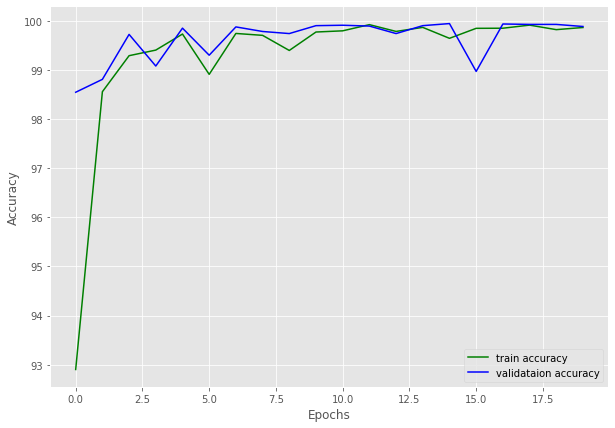

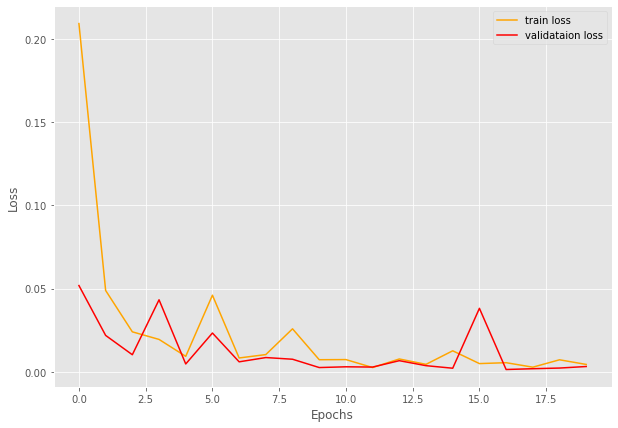

In [11]:
start_time = datetime.now()

dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

# Learning_parameters. 
lr = 0.001  
epochs = 20 
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

model = MedicalMNISTCNN(num_classes=len(dataset_classes)).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-' * 50)

# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print('TRAINING COMPLETE')


# Testing the Trained Model on the Unseen Data

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from model import MedicalMNISTCNN
from sklearn.metrics import confusion_matrix
# Constants and other configurations.
TEST_DIR = 'C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/input/medical_mnist_processed/test'
BATCH_SIZE = 1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IMAGE_RESIZE = 224
NUM_WORKERS = 4
CLASS_NAMES = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

# Define the model architecture.
class MedicalMNISTCNN(nn.Module):
    def __init__(self, num_classes=None):
        super(MedicalMNISTCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout2d(p=0.4),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.classifier(x)
        return x

def test_transform(IMAGE_RESIZE):
    transform = transforms.Compose([
            transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
                )
        ])
    return transform

def create_test_set():
    dataset_test = datasets.ImageFolder(
        TEST_DIR, 
        transform=(test_transform(IMAGE_RESIZE))
    )
    return dataset_test

def create_test_loader(dataset_test):
    test_loader = DataLoader(
        dataset_test, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return test_loader

def save_test_results(tensor, target, output_class, counter):
    """
    This function will save a few test images along with the 
    ground truth label and predicted label annotated on the image.

    :param tensor: The image tensor.
    :param target: The ground truth class number.
    :param output_class: The predicted class number.
    :param counter: The test image number.
    """
    # Move tensor to CPU and denormalize
    image = torch.squeeze(tensor, 0).cpu().numpy()
    image = image / 2 + 0.5
    image = np.transpose(image, (1, 2, 0))
    # Conver to BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = target.cpu().numpy()
    cv2.putText(
        image, f"GT: {CLASS_NAMES[int(gt)]}", 
        (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 
        0.7, (0, 255, 0), 2, cv2.LINE_AA
    )
    cv2.putText(
        image, f"Pred: {CLASS_NAMES[int(output_class)]}", 
        (5, 55), cv2.FONT_HERSHEY_SIMPLEX, 
        0.7, (0, 255, 0), 2, cv2.LINE_AA
    )
    cv2.imwrite(f"C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/test_image_{counter}.png", image*255.)

def test(model, testloader, DEVICE):
    """
    Function to test the trained model on the test dataset.

    :param model: The trained model.
    :param testloader: The test data loader.
    :param DEVICE: The computation device.

    Returns:
        predictions_list: List containing all the predicted class numbers.
        ground_truth_list: List containing all the ground truth class numbers.
        acc: The test accuracy.
    """
    model.eval()
    print('Testing model')
    predictions_list = []
    ground_truth_list = []
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass.
            outputs = model(image)
            # Softmax probabilities.
            predictions = F.softmax(outputs).cpu().numpy()
            # Predicted class number.
            output_class = np.argmax(predictions)
            # Append the GT and predictions to the respective lists.
            predictions_list.append(output_class)
            ground_truth_list.append(labels.cpu().numpy())
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()

            # Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)

    acc = 100. * (test_running_correct / len(testloader.dataset))
    return predictions_list, ground_truth_list, acc


## Final Main

In [7]:
start_time = datetime.now()

dataset_test = create_test_set()
test_loader = create_test_loader(dataset_test)

checkpoint = torch.load('C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/model.pth')
model = MedicalMNISTCNN(num_classes=6).to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
predictions_list, ground_truth_list, acc = test(
    model, test_loader, DEVICE
)

print(f"Test accuracy: {acc:.3f}%")
# Confusion matrix.
conf_matrix = confusion_matrix(ground_truth_list, predictions_list)
plt.figure(figsize=(12, 9))
sns.heatmap(
    conf_matrix, 
    annot=True,
    xticklabels=CLASS_NAMES, 
    yticklabels=CLASS_NAMES
)
plt.savefig('C:/Users/khale/Training_a_Custom_PyTorch_Classifier_on_Medical_MNIST_Dataset/outputs/heatmap.png')
plt.close()

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Testing model


<ipython-input-6-88ce55864b62>:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = F.softmax(outputs).cpu().numpy()



Test accuracy: 100.000%
Duration: 0:04:12.092195


# Confusion matrix before modification of model

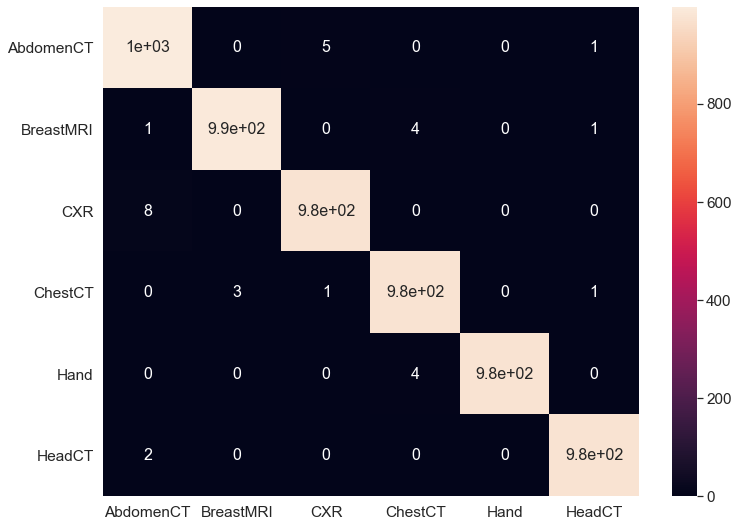

In [16]:
import pandas as pd 

array = [[997, 0, 5, 0, 0, 1],
         [1, 992, 0, 4, 0, 1],
         [8, 0, 977, 0, 0, 0],
         [0, 3, 1, 977, 0, 1],
         [0, 0, 0, 4, 977, 0],
         [2, 0, 0, 0, 0, 977]]

df_cm = pd.DataFrame(array)

plt.figure(figsize=(12, 9))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot=True, annot_kws={"size": 16}) # font size
plt.show()